In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
import time
import shutil
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
# import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim
from tqdm import tqdm
import sklearn
from sklearn.metrics import confusion_matrix

In [5]:
if torch.cuda.is_available():
    print(f"#GPUs           : {torch.cuda.device_count()}")
    print(f"GPU Model       : {torch.cuda.get_device_name()}")
    print(f"GPU total memory: {torch.cuda.get_device_properties(0).total_memory / 1e9}")

#GPUs           : 1
GPU Model       : Tesla P100-PCIE-16GB
GPU total memory: 17.059545088


In [6]:
# Reset GPU memory
from numba import cuda

device = cuda.get_current_device()
device.reset()

In [7]:
data_path = "/kaggle/input/computer-vision-classification/EuroSAT_RGB/"
base_path = "/kaggle/working/" # os.getcwd()

train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")

In [40]:
try:
    os.mkdir(train_path)
    os.mkdir(test_path)
except:
    shutil.rmtree(train_path)
    shutil.rmtree(test_path)
    os.mkdir(train_path)
    os.mkdir(test_path)

In [8]:
os.listdir( os.getcwd() )

['train', 'test', '.virtual_documents', 'state.db']

In [9]:
img_folders = os.listdir( data_path )
img_folders.sort()

print(img_folders)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [10]:
import os
import shutil
import random

def split_data(data_path, img_folder, train_path, test_path, class_name, train_pct=0.8):
    """
    Splits images in a folder into training and testing datasets.

    Parameters:
    - data_path: str, path to the root data directory.
    - img_folder: str, name of the folder containing images.
    - train_path: str, path to store training data.
    - test_path: str, path to store testing data.
    - class_name: str, subfolder name for the class.
    - train_pct: float, percentage of images for the training set.
    """
    print(f"Splitting the folder {img_folder}...\n")

    # Get image files
    images = os.listdir(os.path.join(data_path, img_folder))

    if not images:
        print(f"No images found in folder: {img_folder}")
        return

    # Determine sample sizes
    sample_size = int(len(images) * train_pct)
    train = []
    out_train_path = os.path.join(train_path, class_name)
    out_test_path = os.path.join(test_path, class_name)

    # Ensure directories exist
    for path in [out_train_path, out_test_path]:
        if os.path.exists(path):
            if os.path.isdir(path):
                shutil.rmtree(path)
            else:
                os.remove(path)
        os.mkdir(path)

    # Create train and test splits
    for file in random.sample(images, sample_size):
        shutil.copy2(
            os.path.join(data_path, img_folder, file),
            out_train_path
        )
        train.append(file)

    test = list(set(images) - set(train))
    for file in test:
        shutil.copy2(
            os.path.join(data_path, img_folder, file),
            out_test_path
        )


In [44]:
class_name = 0 
class_dict = {}

for img_folder in img_folders:

    split_data(data_path, img_folder, train_path, test_path, str(class_name), train_pct=0.8)
    class_dict[class_name] = img_folder
    class_name += 1

Splitting the folder AnnualCrop...

Splitting the folder Forest...

Splitting the folder HerbaceousVegetation...

Splitting the folder Highway...

Splitting the folder Industrial...

Splitting the folder Pasture...

Splitting the folder PermanentCrop...

Splitting the folder Residential...

Splitting the folder River...

Splitting the folder SeaLake...



### pre-processing

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )
])

In [12]:
def get_data_loaders(training_data_path, testing_data_path, transform, batch_size, num_workers):

    train_dataset = torchvision.datasets.ImageFolder(root=training_data_path, transform=transform)
    test_dataset  = torchvision.datasets.ImageFolder(root=testing_data_path, transform=transform)

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers
    )
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size=1, 
        shuffle=True, 
        num_workers=num_workers
    )

    return train_dataloader, test_dataloader

In [13]:
train_path

'/kaggle/working/train'

In [14]:
train_dataloader, test_dataloader = get_data_loaders(train_path, test_path, transform, batch_size=64, num_workers=2)

In [15]:
train_dataloader

In [16]:
def show_image(img): 
    img = img / 2 + 0.5
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

In [17]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

In [18]:
class_dict

NameError: name 'class_dict' is not defined

In [19]:
class_dict = {
 0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'
}

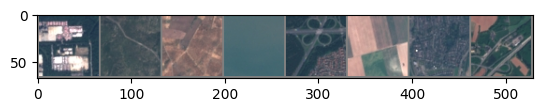

In [20]:
show_image(
    torchvision.utils.make_grid(images[:8])
)

In [21]:
for label in labels[:8]:
    print(class_dict[int(label)])

Industrial
HerbaceousVegetation
PermanentCrop
SeaLake
Highway
AnnualCrop
Residential
Highway


### model

In [22]:
from torch import nn

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomNet(nn.Module):
    def __init__(self, input_shape):
        super(CustomNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
        
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Calcula automaticamente o tamanho da entrada para fc1
        flat_size = self._get_flat_size(input_shape)
        self.fc1 = nn.Linear(flat_size, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)

    def _get_flat_size(self, input_shape):
        """Calculate the input vector size to be used in the FC layer"""
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.conv1(x)
            x = F.relu(x)
            x = self.conv2(x)
            x = F.relu(x)
            x = self.conv3(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = F.max_pool2d(x, 2)

        x = self.dropout1(x)
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)

        x = self.fc4(x)

        return F.log_softmax(x, dim=1)


# Configuração do dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inicializando o modelo com o tamanho da entrada
input_shape = (3, 64, 64)  # Entrada: 3 canais (RGB), 64x64 imagens
model = CustomNet(input_shape).to(device)

# Exemplo de entrada
example_input = torch.randn(8, *input_shape).to(device)  # Lote de 8 imagens
output = model(example_input)

print(output.shape)  # Deve retornar [8, 10]

torch.Size([8, 10])


In [35]:
CustomNet()

CustomNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

In [25]:
input_shape = (3, 64, 64)  # Entrada: 3 canais (RGB), 64x64 imagens
model = CustomNet(input_shape).to(device)

In [26]:
from torch import optim

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [28]:
EPOCHS = 30

In [29]:
test_iter = iter(test_dataloader)

In [30]:
%%time
print("Starting training")

for epoch in range(EPOCHS):

    running_loss = 0.0

    i = 0
    for data in (pbar:=tqdm(train_dataloader)):

        # pbar.set_description(f"\nEpoch {epoch}")

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        total_correct = 0
        total_samples = 0

        if i % 100 == 0:
            with torch.no_grad():
                test_images, test_labels = next(test_iter)
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                test_outputs = model(test_images[:8])
                _, predicted = torch.max(test_outputs, 1)

        i += 1
    print(f"Epoch {epoch}, Loss: {running_loss / (i)}")

print("Finished the training step...")

Starting training


100%|██████████| 338/338 [00:51<00:00,  6.54it/s]


Epoch 0, Loss: 1.276057985583706


100%|██████████| 338/338 [00:51<00:00,  6.58it/s]


Epoch 1, Loss: 0.7238271361624701


100%|██████████| 338/338 [00:51<00:00,  6.56it/s]


Epoch 2, Loss: 0.5163141179543275


100%|██████████| 338/338 [00:51<00:00,  6.56it/s]


Epoch 3, Loss: 0.3529761195976353


100%|██████████| 338/338 [00:51<00:00,  6.56it/s]


Epoch 4, Loss: 0.23119950271349335


100%|██████████| 338/338 [00:51<00:00,  6.56it/s]


Epoch 5, Loss: 0.14995902407495582


100%|██████████| 338/338 [00:51<00:00,  6.56it/s]


Epoch 6, Loss: 0.11670159887985365


100%|██████████| 338/338 [00:51<00:00,  6.56it/s]


Epoch 7, Loss: 0.10271958093167168


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 8, Loss: 0.08203780940822022


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 9, Loss: 0.08058954001343727


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 10, Loss: 0.07159485557246072


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 11, Loss: 0.060452613183269666


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 12, Loss: 0.04691492015659153


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 13, Loss: 0.04933447771331643


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 14, Loss: 0.0414102635222016


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 15, Loss: 0.04336036837616895


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 16, Loss: 0.045912929528091305


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 17, Loss: 0.04630999942861233


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 18, Loss: 0.0446089200369639


100%|██████████| 338/338 [00:51<00:00,  6.58it/s]


Epoch 19, Loss: 0.037317804018856635


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 20, Loss: 0.04356994694505251


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 21, Loss: 0.03480603070185691


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 22, Loss: 0.028736056479570813


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 23, Loss: 0.03435219963776789


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 24, Loss: 0.035700951468533755


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 25, Loss: 0.04365325648453071


100%|██████████| 338/338 [00:51<00:00,  6.58it/s]


Epoch 26, Loss: 0.026512998435125355


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 27, Loss: 0.012697269523206569


100%|██████████| 338/338 [00:51<00:00,  6.57it/s]


Epoch 28, Loss: 0.035382574347771575


100%|██████████| 338/338 [00:51<00:00,  6.58it/s]

Epoch 29, Loss: 0.034565707573848595
Finished the training step...
CPU times: user 25min 15s, sys: 24.6 s, total: 25min 39s
Wall time: 25min 43s


In [31]:
total_correct = 0
total_samples = 0

In [32]:
model.eval()

with torch.no_grad():
    for data in (pbar := tqdm(test_dataloader)):        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

100%|██████████| 5400/5400 [00:29<00:00, 185.33it/s]


In [33]:
accuracy = total_correct/total_samples
accuracy

0.827037037037037

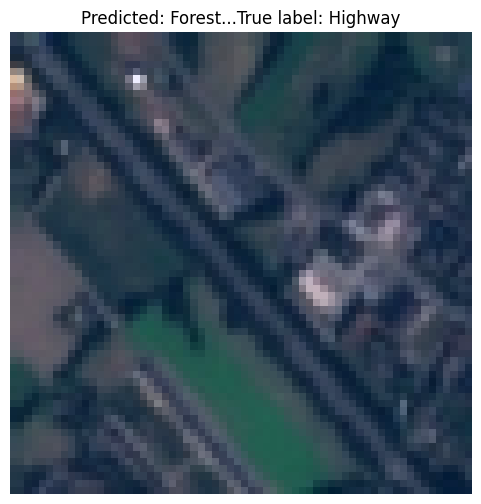

In [38]:
with torch.no_grad():
    data_iter = iter(test_dataloader)
    data = next(data_iter)

    inputs, label = data
    image = inputs[0].unsqueeze(0).to(device)

    output = model(image)
    _, predicted = torch.max(outputs, 1)

    np_image = image.cpu().numpy()[0]
    np_image = np.transpose(np_image, (1, 2, 0))

    if np_image.shape[2] == 1: # [H, W, C]
        np_image = np.squeeze(np_image, axis=2)
    elif np_image.shape[2] == 3:
        np_image = (np_image - np_image.min()) / (np_image.max() - np_image.min())

    plt.figure(figsize=(6, 6))
    plt.imshow(np_image)
    plt.title(f'Predicted: {class_dict[predicted.item()]}...True label: {class_dict[label.item()]}')
    plt.axis('off')
    plt.show()